# K-means model to classify voids in a Ti6Al4V weld

In this tutorial we program and use the K-means algorithm to classify a population of 3D voids obtained by X-ray tomography. The goal of the tutorial is to create 5 differents classes for the voids based on their morphology.
Thanks to Hugo Launay, Laurent Lacourt and David Ryckelynck for sharing the data set.
![](https://github.com/heprom/cvml/blob/main/tutorials/weld_defects.png?raw=true)

Run the notebook in Google colab:
https://colab.research.google.com/github/heprom/cvml/blob/main/tutorials/voids_kmeans.ipynb

In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt, matplotlib.cm as cm

# Data pre-processing

## Loading the data set
Start by loading the complete data set into memory, the data is stored into a compressed numpy array file: `void_shapes.npz` and can be loaded simply using `np.load`

In [2]:
import numpy as np
npz_data = np.load('void_shapes.npz')
data = npz_data['shapes']

Look how many data points we have

In [4]:
print('Number of data points : ', len(data))

Number of data points :  4417


Observe that each data point is a numpy array of size (40 x 40 x 40) in binary form (either 0 or 1). For the latter you can use the function `np.unique`.

In [6]:
# output the shape of the first data point
print(data[1].shape)

# output the different values in the data set
print(np.unique(data))

(40, 40, 40)
[0 1]


## plotting the data
At this point, it is useful to hava a look at the data. We will do this by plotting randomly a few voids in 2D (summing up the third dimension)

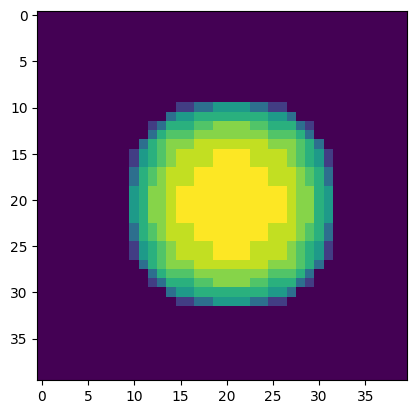

In [15]:
# first display the first void by summing the 3D array on the third dimension
plt.imshow(np.sum(data[0], axis=2))

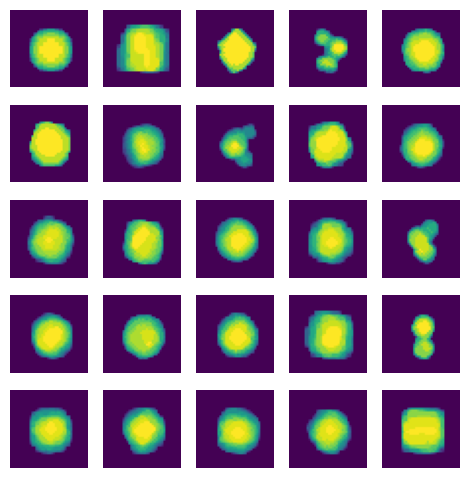

In [22]:
# now plot 25 data points with a mosaic of small images
n = 5
plt.figure(figsize=(n, n))
for j in range(n):
    for i in range(n):
        index = n * j + i
        axi = plt.subplot(n, n, index + 1)
        axi.imshow(np.sum(data[index], axis=2))
        axi.axis('off')
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.04, top=0.96)
plt.show()

## Feature engineering
Now we have a better understanding of the natude of the data, we will compute some features: **volume** and **sphericity**

The volume (in voxels) can be simply computed by summing all voxels that equals 1. As other voxels equals 0, we can simply sum all voxels.

$V_i=\sum_{v\in data[i]}v$

In [23]:
volumes = np.sum(data, axis=(1, 2, 3))
print(volumes.shape)

(4417,)


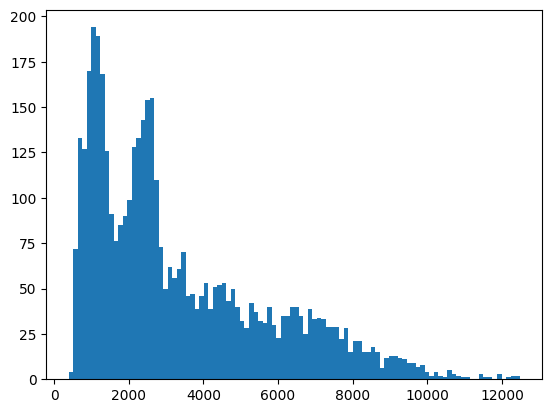

In [24]:
plt.hist(volumes, bins=100)
plt.show()

The sphericity measures how close to a sphere is a given void (or particle). It can be computed by the ratio between the ideal surface area and the actual surface area of that void $A_i$. The ideal surface area is the surface area of a sphere with the same volume.

$\psi_i = \dfrac{\pi^{1/3}(6V_i)^{2/3}}{A_i}$

To compute the surface area of each void we will simply count each voxel on the surface. This can be done by constructing the difference between a void and its erosion by 1 pixel. We can use the `binary_erosion` from the `scipy.ndimage.morphology` package.

<ipython-input-30-39822f5707e0>:1: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_erosion


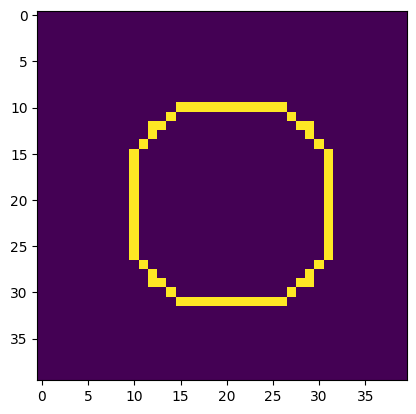

In [30]:
from scipy.ndimage.morphology import binary_erosion

surface = data[0] - binary_erosion(data[0], iterations=1)
plt.imshow(surface[:, :, 20].T)

Compute the surface area for each void

In [33]:
surface_areas = [np.sum(data[i] - binary_erosion(data[i])) for i in range(4417)]

Compute the sphericity for each void

In [34]:
sphericities = np.pi**(1/3) * (6 * volumes) ** (2/3) / surface_areas

Plot the distribution of sphericities

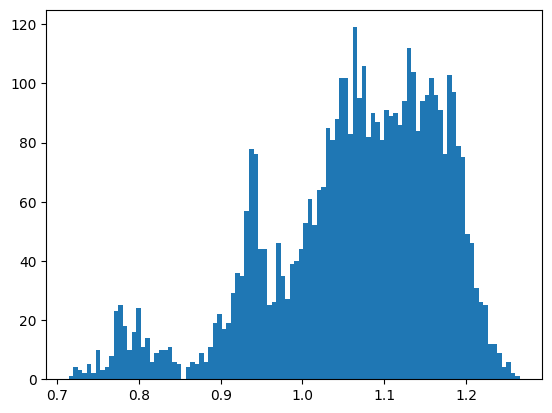

In [35]:
plt.hist(sphericities, bins=100)
plt.show()

Finally, visualize our 2 features in a plot

Text(0, 0.5, 'Void sphericity')

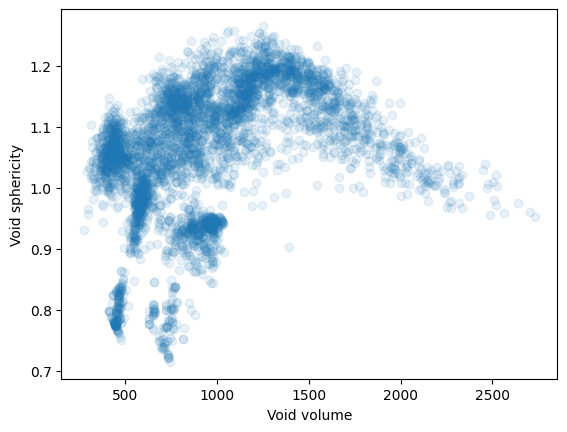

In [36]:
plt.plot(surface_areas, sphericities, 'o', alpha=0.1)
plt.xlabel('Void volume')
plt.ylabel('Void sphericity')

## data normalization

This is a good example where we will have to normalize the data so that both volume and sphericity have the same weigth in the distance calculation (K-means is very sensitive to data normalization).

In [38]:
volumes_norm = (volumes -np.mean(volumes)) / np.std(volumes)
sphericities_norm = (sphericities -np.mean(sphericities)) / np.std(sphericities)

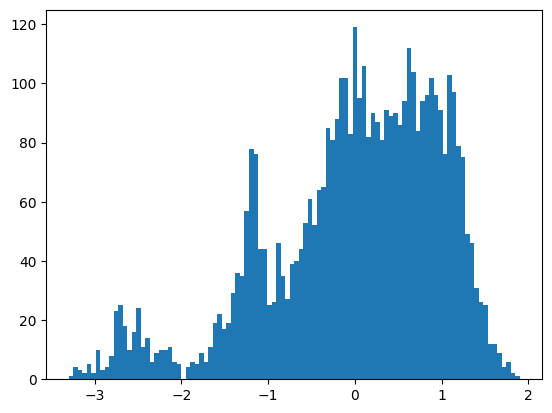

In [40]:
plt.hist(sphericities_norm, bins=100)
plt.show()

In [41]:
sphericities_norm = np.clip(sphericities_norm, -3, 3)

# K-means algorithm

In the K-means algorithm, the number of classes is fixed (it is a hyper-parameter)

In [45]:
K = 5  # number of classes
void_data = np.vstack([volumes_norm, sphericities_norm]).T
print(void_data.shape)
n = len(void_data)  # number of data points
distances= np.zeros(K)  # an array to compute the distance to all centroids for a given point

(4417, 2)


In [43]:
labels = np.zeros(n, dtype=np.uint8)

In [60]:
# picks the initial centroids randomly
centroid_indices = np.random.choice(n, K, replace=False)
print(centroid_indices)
centroids = np.array([void_data[i] for i in centroid_indices])
print(centroids)

[1391    7 1650 1910 3761]
[[-1.00678247 -1.61597156]
 [-0.38243221  0.28862975]
 [-0.71929679 -0.41133662]
 [-1.11893118 -2.30447636]
 [-0.57701858 -1.89744847]]


Create a function to compute the labels for all the data points given the centroids

In [61]:
def compute_labels():
    """compute the labels for all the data points given the centroids."""
    for i in void_data:
        # compute the distance with each centroid for this data point
        for k in centroids:
            distances[k] = np.linalg.norm(i-k)
        labels[i] = np.argmin(distances)

Create a function to compute the $K$ centroids points given the labels

In [63]:
def compute_centroids():
    """compute the new centroids given the labels."""
    for k in centroids:
        # get all the point in cluster k and average them
        centroids[k] = np.mean(void_data[labels == k], axis=0)

Now run the algorithm: at each step we compute the labels (given the centroids) and then compute the centroids (given the labels). We stop when the centroids did not change with respect to the previous iteration or if we reach a maximum number of iterations.

In [ ]:
# run the K-means algorithm
max_iter = 50
iter = 1

previous_centroids = ...
...  # compute labels
...  # compute centroids

while ...:
    print('K-means iteration %d' % iter)
    previous_centroids = centroids.copy()
    ...  # compute labels
    ...  # compute centroids
    iter += 1

print('done')

Make a scatter plot to visualize our classification

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(..., ..., c=labels, alpha=0.5)  # data points
plt.scatter(..., ..., c=range(K), marker='s', edgecolors='k', s=60)  # centroids
plt.xlabel('Void volume (normalized)')
plt.ylabel('Void sphericity (normalized)')
plt.legend(handles=scatter.legend_elements()[0], labels=['1', '2', '3', '4', '5'], title='Class')

## Plot a representant of each class
We use the closest data point from the centroid to find the best representatn of each class.

In [ ]:
# find the closest data point to each class
representants = np.empty(K, dtype=int)
all_distances = np.zeros(n)

for k in range(K):
    for i in range(n):
        all_distances[i] = ...
    representants[k] = ...
print(representants)

In [ ]:
void_data[representants]

In [ ]:
plt.figure(figsize=(10, 2))
for k in range(K):
    ax = plt.subplot(1, K, k + 1)
    ax.imshow(np.sum(data[representants[k]].T, axis=2), interpolation='nearest')
    ax.axis('off')
    ax.set_title('k=%d' % (k + 1))
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.04, top=0.96)
plt.show()

## bonus: plotting the voids in 3D

Here you have the code to visualize the voids in 3D using a voxel representation

In [ ]:
l = 40
x, y, z = np.mgrid[0:l, 0:l, 0:l]
data_ = np.indices((l, l, l))[0] * np.indices((l, l, l))[1] * np.indices((l, l, l))[2]
data_ = data_ / np.max(data_.astype(float))
alpha = 1.
colors = plt.cm.cool(data_) * [1, 1, 1, alpha]

In [ ]:
fig = plt.figure(figsize=(K * 5, 5))
for k in range(K):
    ax = fig.add_subplot(1, K, k + 1, projection='3d')
    ax.voxels(data[representants[k]], facecolors=colors, edgecolor='k')
    ax.view_init(elev=40., azim=145)
    ax.grid(False)
    ax.set_title('k=%d' % (k + 1))
    plt.axis('tight')
    plt.axis('off')
plt.show()

# Using K-means with scikit-learn

Here you will find the code to use K-means with the popular machine learning package scikit-learn. You are encouraged to learn to use this package altough writting code yourself is always a good exercice.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=..., random_state=42).fit(...)

In [ ]:
y = kmeans.fit_predict(...)

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(volumes_norm, sphericities_norm, c=y, alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c=range(K), marker='s', edgecolors='k', s=60)
plt.xlabel('Void volume (normalized)')
plt.ylabel('Void sphericity (normalized)')
plt.legend(handles=scatter.legend_elements()[0], labels=['1', '2', '3', '4', '5'], title='Class')